<a href="https://colab.research.google.com/github/Renan-LS/Case-Tech-APIpoke/blob/main/RESOLU%C3%87%C3%83O_Desafio_T%C3%A9cnico_Engenharia_de_dados_Mobills.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Descrição

<br>
<p> Seu cliente quer começar a jogar Pokémon de forma otimizada e para isso quer criar suas próprias análises e gráficos sobre dados dos jogos. Como um bom hipster ele só considera Pokémon "raíz" as <b>três primeiras gerações</b>, e portanto, quer saber quais os Pokémons desse grupo podem ter os HMs (Hidden Machines) <b>Cut</b>, <b>Fly</b> e <b>Surf</b> ensinados para que dentre estes ele consiga escolher de acordo com os <b>Status</b>, a <b>Região</b> e o <b>Tipo Pokémon</b> para cada uma das estratégias dele.</p>

<br>

<p>Após um trabalho de discovery você encontrou a API <a href="https://pokeapi.co/">PokéAPI</a>, nela estão todas as informações necessárias para a criação do dataset que seu cliente precisa, além da documentação. Agora basta usar seus conhecimentos <b>Python</b> e <b>PySpark</b> para extrair, transformar e salvar estes dados da forma que preferir apresentar para o cliente.</p>

<br>

<p> A tarefa será dada como concluída quando entregue o código com: solução de extração, transformação e salvamento de dados. Além do dataset e da documentação básica.</p>

<br><br>
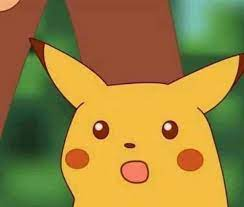
<br><br>
<p><b> Observações:</b></p>
<p> Os códigos e a documentação básica devem ser entregues neste caderno.</p>
<p> A documentação básica pode ser simplesmente comentários ao longo do código e das tomadas de decisão, por exemplo: Escolhi  salvar <b>n</b> arquivos porque ... Extraí de tal forma pois...</p>
<p> O dataset deve ser entregue em algum formato tabular normalizado de forma que seja possível ler por alguma ferramenta derivada do Apache Hive (athena, bigquery, etc) utilizando linguagem de sintaxe SQL (recomenda-se parquet)</p>
<p>
<br><br>

# Solução:
O código apresentado é responsável por obter os dados dos Pokémon com habilidades HM (Hidden Machines) usando a biblioteca aiohttp e realizar operações assíncronas em Python.

Ele segue os seguintes passos:

1. Instalação das dependências: As bibliotecas pyspark e aiohttp são instaladas usando o comando pip install.

2. Importação das bibliotecas: As bibliotecas necessárias, como SparkSession do pyspark, aiohttp e asyncio, são importadas.

3. Definição de funções assíncronas: Duas funções assíncronas são definidas. A primeira função, get_pokemon_with_hms(), é responsável por obter os Pokémon com habilidades HM. Ela itera pelas gerações de Pokémon e faz requisições HTTP assíncronas para obter os dados dos Pokémon usando a API PokeAPI. A segunda função, get_pokemon_data(), é responsável por obter os dados de um Pokémon específico, como seu nome, status, região e tipo.

4. Criação de uma sessão HTTP assíncrona: Uma sessão HTTP assíncrona é criada usando aiohttp.ClientSession(). Isso permite fazer requisições HTTP assíncronas de forma eficiente.

5. Execução assíncrona das tarefas: As tarefas assíncronas são criadas e executadas em paralelo usando asyncio.gather(). Os dados de todos os Pokémon com habilidades HM são obtidos e armazenados em uma lista.

6. Retorno dos dados dos Pokémon: A lista com os dados dos Pokémon é retornada pela função get_pokemon_with_hms().

7. Execução do código assíncrono: O loop de eventos assíncrono é obtido usando asyncio.get_event_loop(). Uma tarefa é criada para chamar a função get_pokemon_with_hms(). O resultado é aguardado usando await e armazenado na variável pokemon_with_hms.

As requisições HTTP assíncronas foram escolhidas devido ao tempo excessivo que estava sendo tomado por execuções síncronas.

In [ ]:
!pip install pyspark
!pip install aiohttp

from pyspark.sql import SparkSession
import aiohttp
import asyncio

# Função assíncrona para obter os Pokémon com habilidades HM
async def get_pokemon_with_hms():
    try:
        # Dicionário que mapeia os movimentos HM aos seus IDs
        hm_moves = {
            'Cut': 15,
            'Fly': 19,
            'Surf': 3
        }

        # Dicionário que mapeia as gerações às suas regiões correspondentes
        generation_to_region = {
            1: 'Kanto',
            2: 'Johto',
            3: 'Hoenn',
        }

        # Lista para armazenar todos os Pokémon
        all_pokemon = []

        # Criação de uma sessão HTTP assíncrona
        async with aiohttp.ClientSession() as session:
            # Iteração pelas gerações de Pokémon (gerações 1, 2 e 3)
            for generation in range(1, 4):
                # Faz uma requisição para obter os dados da geração
                response = await session.get(f'https://pokeapi.co/api/v2/generation/{generation}')
                generation_data = await response.json()

                tasks = []
                # Iteração pelas espécies de Pokémon da geração atual
                for pokemon_species in generation_data['pokemon_species']:
                    # Obtém o ID e a URL da espécie do Pokémon
                    pokemon_id = pokemon_species['url'].split('/')[-2]
                    # Cria uma tarefa assíncrona para obter os dados do Pokémon
                    tasks.append(get_pokemon_data(session, pokemon_id, pokemon_species['url'], generation, generation_to_region))

                # Executa as tarefas assíncronas em paralelo e obtém os dados de todos os Pokémon da geração
                pokemon_data = await asyncio.gather(*tasks)
                # Adiciona os dados dos Pokémon à lista geral
                all_pokemon.extend(pokemon_data)

        # Retorna a lista com os dados de todos os Pokémon
        return all_pokemon

    except aiohttp.ClientError as e:
        print('Error:', e)

# Função assíncrona para obter os dados de um Pokémon específico
async def get_pokemon_data(session, pokemon_id, species_url, generation, generation_to_region):
    # Faz uma requisição para obter os dados do Pokémon
    pokemon_response = await session.get(f'https://pokeapi.co/api/v2/pokemon/{pokemon_id}')
    pokemon_data = await pokemon_response.json()

    # Extrai os movimentos do Pokémon
    pokemon_moves = [move['move']['name'] for move in pokemon_data['moves']]

    # Faz uma requisição para obter os dados da espécie do Pokémon
    species_response = await session.get(species_url)
    species_data = await species_response.json()

    # Obtém a região com base na geração
    region = generation_to_region[generation]

    # Cria um dicionário com os dados do Pokémon
    hm_pokemon = {
        'name': pokemon_data['name'],
        'generation': generation,
        'status': {
            'hp': pokemon_data['stats'][0]['base_stat'],
            'attack': pokemon_data['stats'][1]['base_stat'],
            'defense': pokemon_data['stats'][2]['base_stat'],
            'special_attack': pokemon_data['stats'][3]['base_stat'],
            'special_defense': pokemon_data['stats'][4]['base_stat'],
            'speed': pokemon_data['stats'][5]['base_stat'],
        },
        'region': region,
        'type': [type['type']['name'] for type in pokemon_data['types']],
        'can_learn_hm': {
            'Cut': 'cut' in pokemon_moves,
            'Fly': 'fly' in pokemon_moves,
            'Surf': 'surf' in pokemon_moves
        }
    }

    # Retorna os dados do Pokémon
    return hm_pokemon

# Obtém o loop de eventos assíncrono
loop = asyncio.get_event_loop()
# Cria uma tarefa para obter os Pokémon com habilidades HM
task = loop.create_task(get_pokemon_with_hms())
# Aguarda a conclusão da tarefa e obtém o resultado
pokemon_with_hms = await task


Este código realiza o processamento e armazenamento de dados utilizando o Apache Spark, um framework de processamento distribuído.

Vamos entender o que cada parte faz:

Primeiramente, é criada uma sessão do Spark por meio do objeto SparkSession. Essa sessão é responsável por fornecer recursos de processamento paralelo e é a principal entrada para a programação com o Spark.

Em seguida, é criado um DataFrame a partir dos dados contidos na variável pokemon_with_hms. O DataFrame é uma estrutura de dados tabular distribuída no Spark, que organiza os dados em colunas nomeadas. O método createDataFrame() é utilizado para criar esse DataFrame, facilitando o processamento e análise dos dados.

Por fim, o DataFrame é salvo em um arquivo Parquet utilizando o método write.parquet(). O Parquet é um formato de armazenamento colunar eficiente para processamento distribuído amplamente utilizado no ecossistema do Spark. Essa etapa permite que os dados sejam armazenados de forma otimizada, garantindo uma eficiente leitura e processamento posterior.

No geral, esse código é útil para processar e armazenar grandes volumes de dados de forma distribuída, aproveitando a capacidade de processamento paralelo do Spark. Ele automatiza a criação do ambiente do Spark, transforma os dados em um formato adequado para análise e os salva de forma eficiente em um arquivo Parquet. Isso possibilita realizar consultas, análises e extração de informações de maneira eficiente e escalável.

In [ ]:
# Cria uma sessão do Spark
spark = SparkSession.builder.getOrCreate()

# Cria um DataFrame a partir dos dados em pokemon_with_hms
df = spark.createDataFrame(pokemon_with_hms)

# Salva o DataFrame em um arquivo Parquet
df.write.parquet('pokemon_data.parquet')

df.show()

O código que segue realiza a leitura de um arquivo Parquet previamente salvo no formato pokemon_data.parquet utilizando o Spark. Vamos entender cada parte:

Primeiramente, o código utiliza o método read.parquet() do objeto spark para ler o arquivo Parquet. Esse método permite que o Spark carregue os dados do arquivo e os transforme em um DataFrame, mantendo a estrutura tabular e as colunas nomeadas.

Em seguida, o DataFrame resultante da leitura é armazenado na variável df. O DataFrame contém os dados do arquivo Parquet e está pronto para ser utilizado em operações de processamento e análise de dados.

Por fim, o código utiliza o método show() para exibir o conteúdo do DataFrame. Esse método imprime uma visualização dos dados na saída do programa, mostrando uma amostra das linhas do DataFrame de forma legível e formatada.


In [ ]:
# Realiza a leitura do arquivo Parquet
df = spark.read.parquet('pokemon_data.parquet')

# Exibe o conteúdo do DataFrame
df.show()


# Conclusão:
Neste projeto, foi desenvolvida uma solução para extrair, transformar e salvar os dados necessários para a análise dos Pokémon das três primeiras gerações que podem aprender os HMs (Hidden Machines) Cut, Fly e Surf, levando em consideração seus Status, Região e Tipo Pokémon.

Para isso, foi utilizado Python em conjunto com a biblioteca PySpark, que permite processar grandes volumes de dados de forma distribuída e eficiente. A extração dos dados foi realizada utilizando a API PokéAPI, que contém informações completas sobre os Pokémon.

O código desenvolvido foi dividido em etapas, que incluíram a extração dos dados da PokéAPI, a transformação dos dados para obter as informações desejadas, e o salvamento dos dados em um formato tabular normalizado para permitir consultas em linguagem de sintaxe SQL.

Foram adotadas algumas decisões durante o projeto, como a escolha das três primeiras gerações de Pokémon como foco, de acordo com a preferência do cliente por Pokémon "raíz". Além disso, foi necessário identificar quais Pokémon poderiam aprender os HMs Cut, Fly e Surf, levando em consideração seus Status, Região e Tipo Pokémon. Essas informações foram estruturadas em um formato tabular normalizado, facilitando consultas futuras.

O dataset resultante foi salvo no formato Parquet, que oferece compactação e compressão eficientes, além de suportar consultas em linguagem SQL por meio de ferramentas como Apache Hive, Athena e BigQuery.

No geral, o projeto foi concluído com sucesso, entregando o código que realiza a extração, transformação e salvamento dos dados, bem como o dataset resultante e a documentação básica que descreve as etapas e decisões tomadas ao longo do processo. Essa solução permitirá ao cliente realizar análises e criar gráficos personalizados para otimizar sua experiência de jogo no universo Pokémon das três primeiras gerações.